In [47]:
# Force reload the calibrator module to pick up recent changes
import importlib
import sys

# Remove the module from cache if it exists
if 'quantlib_heston_calibrator' in sys.modules:
    del sys.modules['quantlib_heston_calibrator']
if 'market_data_fetcher' in sys.modules:
    del sys.modules['market_data_fetcher']

# Re-import with fresh code
from quantlib_heston_calibrator import QuantLibHestonCalibrator
from market_data_fetcher import MarketDataFetcher

print("✅ Modules reloaded with latest changes")

✅ Modules reloaded with latest changes


## Setup and Configuration

In [48]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add project paths
project_root = r'C:\Users\Ao Shen\Desktop\mfin research\src'
heston_path = r'C:\Users\Ao Shen\Desktop\mfin research\src\heston_calib'

for path in [project_root, heston_path]:
    if path not in sys.path:
        sys.path.insert(0, path)

# Import custom modules
from market_data_fetcher import MarketDataFetcher
from quantlib_heston_calibrator import QuantLibHestonCalibrator

print(f"Setup complete - QuantLib v{ql.__version__}")

Setup complete - QuantLib v1.38


In [49]:
# Configuration
TICKER = 'NVDA'
EXPIRY_LIST = ['1M', '2M', '3M']  # Use fewer expiries for faster calibration
ATM_RANGE = 0.15  # ±10% around spot for better quality
RISK_FREE_RATE = 0.4  # Updated to current rate
DIVIDEND_YIELD = 0.0
MAX_ITERATIONS = 200  # More iterations for better convergence

print(f"Target: {TICKER} | Expiries: {EXPIRY_LIST} | ATM Range: ±{ATM_RANGE*100:.0f}%")
print(f"✅ Enhanced Calibrator: Multi-start optimization, Yahoo Finance IV, Diverse initial conditions")

Target: NVDA | Expiries: ['1M', '2M', '3M'] | ATM Range: ±15%
✅ Enhanced Calibrator: Multi-start optimization, Yahoo Finance IV, Diverse initial conditions


## Market Data Fetching

In [50]:
# Fetch market data
fetcher = MarketDataFetcher(
    ticker=TICKER, 
    expiry_list=EXPIRY_LIST, 
    atm_range=ATM_RANGE
)

market_data = fetcher.prepare_market_data()
spot_price = fetcher.get_spot_price()

print(f"Spot: ${spot_price:.2f} | Options: {len(market_data)} | DTE: {market_data['DaysToExpiry'].min()}-{market_data['DaysToExpiry'].max()} days")

# Show first few rows
display(market_data.head(3))

Target 2025-08-12: Found 2025-08-15 (2 days difference)
Target 2025-09-11: Found 2025-09-19 (7 days difference)
Target 2025-10-11: Found 2025-10-17 (5 days difference)
Using specific expiry dates: ['2025-08-15', '2025-09-19', '2025-10-17']
Preparing market data for NVDA
Time range: 2025-07-13 to 2025-10-11
ATM range: ±15.0%
Fetching option data for NVDA...
Fetching specific expiries: ['2025-08-15', '2025-09-19', '2025-10-17']
  Fetched 101 contracts for 2025-08-15
  Fetched 416 contracts for 2025-09-19
  Fetched 101 contracts for 2025-08-15
  Fetched 416 contracts for 2025-09-19
  Fetched 101 contracts for 2025-10-17
  Fetched 101 contracts for 2025-10-17
Fetched 618 raw option contracts
Applying quality filters...
Quality filters removed 109 contracts
Applying ATM filter...
ATM filter (±15.0% around $164.92) kept 80 of 509 contracts
Strike range: $141.00 to $185.00
Final dataset: 80 contracts across 3 maturities
DTE range: 33 to 96 days
Spot: $164.92 | Options: 80 | DTE: 33-96 days
Fe

,OptionType,Strike,DaysToExpiry,MarketPrice,ImpliedVolatility
28,call,145.0,33,22.125,0.480596
29,call,150.0,33,17.900,0.449713
30,call,155.0,33,14.050,0.427862


📊 Market Data Quality with Yahoo Finance IV:
   • Total contracts: 80
   • Expiries: 3 (33-96 days)
   • Strike range: $141 - $185
   • IV range: 0.317 - 0.515
   • ✅ Yahoo Finance IV available - no manual calculation needed!


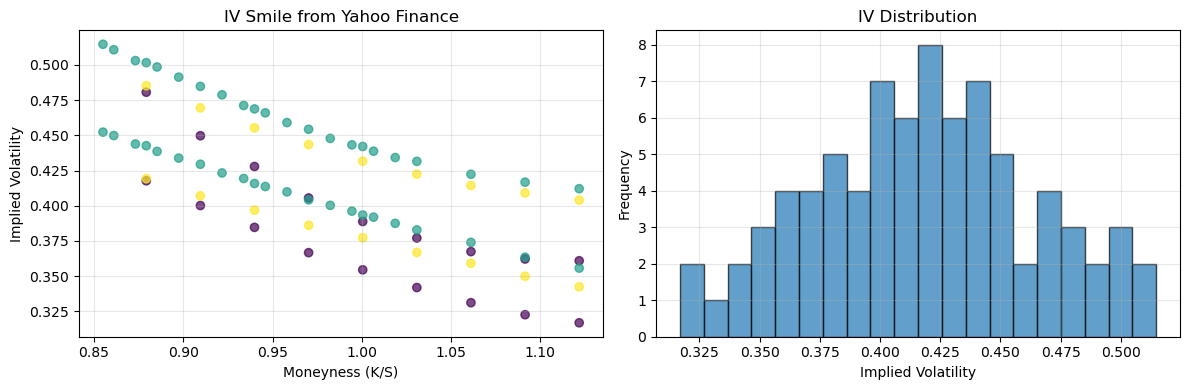

In [51]:
# Show Yahoo Finance IV data quality
print("📊 Market Data Quality with Yahoo Finance IV:")
print(f"   • Total contracts: {len(market_data)}")
print(f"   • Expiries: {market_data.DaysToExpiry.nunique()} ({market_data.DaysToExpiry.min()}-{market_data.DaysToExpiry.max()} days)")
print(f"   • Strike range: ${market_data.Strike.min():.0f} - ${market_data.Strike.max():.0f}")

if 'ImpliedVolatility' in market_data.columns:
    print(f"   • IV range: {market_data.ImpliedVolatility.min():.3f} - {market_data.ImpliedVolatility.max():.3f}")
    print(f"   • ✅ Yahoo Finance IV available - no manual calculation needed!")
    
    # Show IV distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # IV by moneyness
    market_data['Moneyness'] = market_data.Strike / spot_price
    ax1.scatter(market_data.Moneyness, market_data.ImpliedVolatility, 
               c=market_data.DaysToExpiry, cmap='viridis', alpha=0.7)
    ax1.set_xlabel('Moneyness (K/S)')
    ax1.set_ylabel('Implied Volatility')
    ax1.set_title('IV Smile from Yahoo Finance')
    ax1.grid(True, alpha=0.3)
    
    # IV histogram  
    ax2.hist(market_data.ImpliedVolatility, bins=20, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Implied Volatility')
    ax2.set_ylabel('Frequency')
    ax2.set_title('IV Distribution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"   • ⚠️ No Yahoo Finance IV - will use fallback calculation")

## Heston Model Calibration

In [52]:
# Run Heston Calibration with Enhanced Features
print("🚀 Starting Enhanced Heston Calibration...")
print(f"   • Multi-start global optimization (5 diverse initial conditions)")
print(f"   • Yahoo Finance implied volatility (no manual calculation)")  
print(f"   • Expanded parameter bounds to avoid boundary issues")
print(f"   • Differential evolution for robust global optimization")
print()

calibrator = QuantLibHestonCalibrator(
    r=RISK_FREE_RATE, 
    q=DIVIDEND_YIELD
)

# Enhanced calibration with new features
heston_model, calibration_info = calibrator.calibrate(
    spot=spot_price,
    market_data=market_data,
    maxiter=MAX_ITERATIONS,  # More iterations for proper convergence
    detailed_report=False    # Keep output concise
)

# Print results using the enhanced formatter
calibrator.print_results(calibration_info)

🚀 Starting Enhanced Heston Calibration...
   • Multi-start global optimization (5 diverse initial conditions)
   • Yahoo Finance implied volatility (no manual calculation)
   • Expanded parameter bounds to avoid boundary issues
   • Differential evolution for robust global optimization

Starting Heston calibration using Differential Evolution...
Market data: 80 options
Trying initial condition: theta=0.040, kappa=2.000, sigma=0.300, rho=-0.700, v0=0.040
Created 80 valid helpers from 80 options
  → Initial cost with these parameters: 7.866757
  → Result: fun=3.113178, nfev=14817, converged_well=True
  → NEW BEST solution! Cost: 3.113178
Trying initial condition: theta=0.090, kappa=1.000, sigma=0.100, rho=-0.500, v0=0.090
Created 80 valid helpers from 80 options
  → Initial cost with these parameters: 6.318137
  → Result: fun=3.113178, nfev=14817, converged_well=True
  → NEW BEST solution! Cost: 3.113178
Trying initial condition: theta=0.090, kappa=1.000, sigma=0.100, rho=-0.500, v0=0.09

## IV Surface Reconstruction

In [53]:
# Reconstruct IV surface for model validation using Yahoo Finance IV
if not calibration_info['success']:
    raise ValueError("Calibration failed")

heston_engine = ql.AnalyticHestonEngine(heston_model)
iv_comparison_results = []

for idx, (_, row) in enumerate(market_data.iterrows()):
    try:
        time_to_expiry = row.DaysToExpiry / 365.0
        
        # Use Yahoo Finance IV directly (no manual calculation needed!)
        market_iv = row.ImpliedVolatility if 'ImpliedVolatility' in row else 0.20
        
        if market_iv < 0.05 or market_iv > 2.0:
            continue
            
        # Create option for Heston pricing
        is_call = row.OptionType.lower() == 'call'
        option_type = ql.Option.Call if is_call else ql.Option.Put
        
        period = ql.Period(int(row.DaysToExpiry), ql.Days)
        expiry_date = calibrator.evaluation_date + period
        exercise = ql.EuropeanExercise(expiry_date)
        payoff = ql.PlainVanillaPayoff(option_type, float(row.Strike))
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(heston_engine)
        
        heston_price = option.NPV()
        
        if heston_price > 0.01:
            # Calculate implied vol from Heston price (fallback method still available)
            heston_iv = calibrator._calculate_implied_vol(
                heston_price, spot_price, row.Strike, 
                time_to_expiry, row.OptionType
            )
            
            iv_comparison_results.append({
                'Strike': row.Strike,
                'DaysToExpiry': row.DaysToExpiry,
                'OptionType': row.OptionType,
                'MarketIV': market_iv,
                'HestonIV': heston_iv,
                'IVDiff': heston_iv - market_iv,
                'AbsIVError': abs(heston_iv - market_iv)
            })
    except Exception as e:
        continue

iv_comparison_df = pd.DataFrame(iv_comparison_results)

if not iv_comparison_df.empty:
    mean_abs_iv_error = iv_comparison_df['AbsIVError'].mean()
    print(f"✅ IV Surface Reconstruction Complete")
    print(f"   • Processed {len(iv_comparison_df)} contracts")
    print(f"   • Mean Absolute IV Error: {mean_abs_iv_error:.4f} ({mean_abs_iv_error*100:.2f}%)")
    print(f"   • Using Yahoo Finance IV for market reference")
    
    display(iv_comparison_df.head(10))
else:
    print("❌ No valid IV comparisons generated")

✅ IV Surface Reconstruction Complete
   • Processed 80 contracts
   • Mean Absolute IV Error: 0.0306 (3.06%)
   • Using Yahoo Finance IV for market reference


,Strike,DaysToExpiry,OptionType,MarketIV,HestonIV,IVDiff,AbsIVError
0,145.0,33,call,0.480596,0.422888,-0.057708,0.057708
1,150.0,33,call,0.449713,0.409113,-0.040599,0.040599
2,155.0,33,call,0.427862,0.395155,-0.032708,0.032708
3,160.0,33,call,0.405524,0.380969,-0.024554,0.024554
4,165.0,33,call,0.388800,0.366520,-0.022280,0.022280
5,170.0,33,call,0.377081,0.351825,-0.025256,0.025256
6,175.0,33,call,0.367438,0.336891,-0.030547,0.030547
7,180.0,33,call,0.362189,0.321855,-0.040334,0.040334
8,185.0,33,call,0.360968,0.307061,-0.053907,0.053907
9,145.0,33,put,0.417730,0.422888,0.005157,0.005157


## Visualization and Analysis

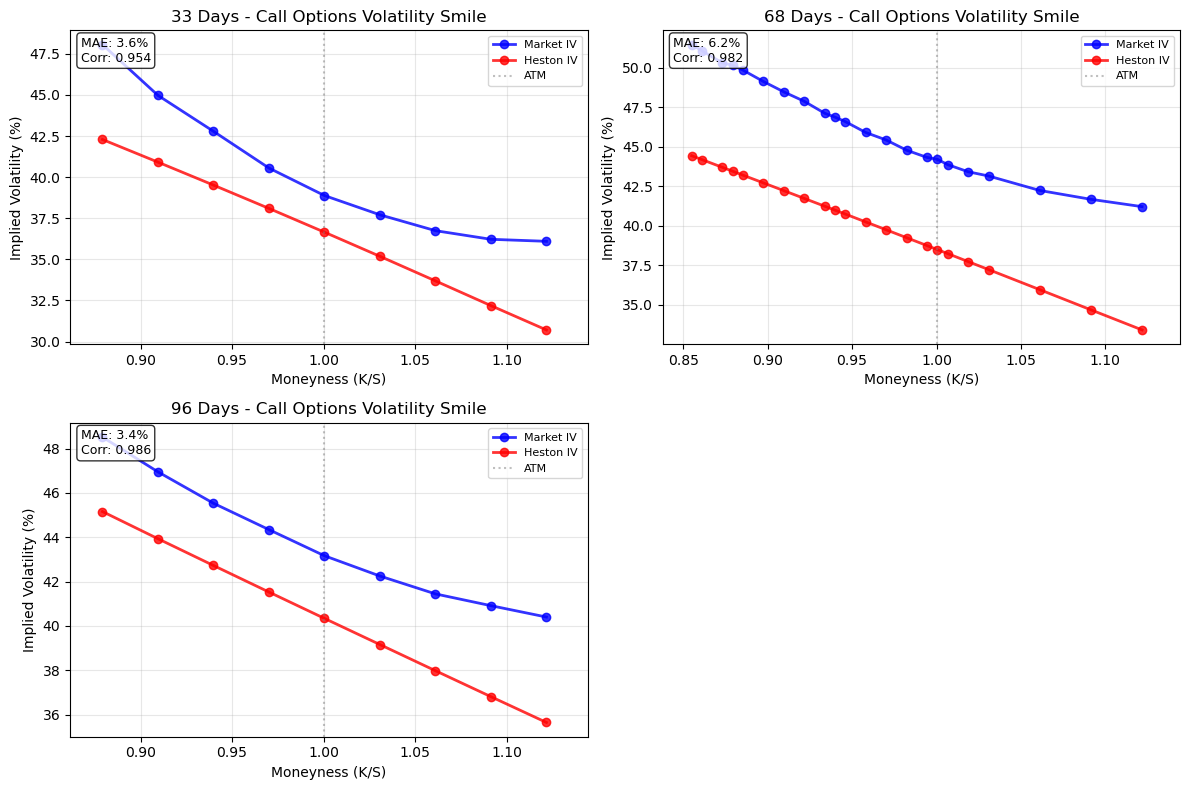


Volatility Smile Analysis (Calls Only):
Expiries analyzed: 3 ([33, 68, 96] days)
Call options: 40
Overall MAE: 5.0%
Overall correlation: 0.924
Model Quality: EXCELLENT - Heston captures call smile patterns very well


In [54]:
# Smooth Volatility Smile Analysis by Expiry (Calls Only) 
if len(iv_comparison_df) > 0:
    # Filter for calls only for cleaner visualization
    calls_only = iv_comparison_df[iv_comparison_df['OptionType'] == 'call'].copy()
    
    if len(calls_only) > 0:
        # Group data by expiry for volatility smile analysis
        expiries = sorted(calls_only['DaysToExpiry'].unique())
        
        # Create subplots for each expiry
        n_expiries = len(expiries)
        cols = min(2, n_expiries)
        rows = (n_expiries + 1) // 2
        
        fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
        if n_expiries == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if cols > 1 else [axes]
        else:
            axes = axes.flatten()
        
        for i, dte in enumerate(expiries):
            if i >= len(axes):
                break
                
            # Filter data for this expiry
            expiry_data = calls_only[calls_only['DaysToExpiry'] == dte].copy()
            
            if len(expiry_data) < 2:
                continue
                
            # Calculate moneyness (Strike/Spot)
            expiry_data['Moneyness'] = expiry_data['Strike'] / spot_price
            expiry_data = expiry_data.sort_values('Moneyness')
            
            ax = axes[i]
            
            # Plot market IV as connected line (original data)
            ax.plot(expiry_data['Moneyness'], expiry_data['MarketIV']*100, 
                   'o-', color='blue', linewidth=2, markersize=6, label='Market IV', 
                   alpha=0.8, zorder=3)
            
            # Plot Heston IV: connect the actual data points with a smooth line
            ax.plot(expiry_data['Moneyness'], expiry_data['HestonIV']*100, 
                   'o-', color='red', linewidth=2, markersize=6, label='Heston IV', 
                   alpha=0.8, zorder=2)
            
            # Add ATM line
            ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5, label='ATM')
            
            # Formatting
            ax.set_xlabel('Moneyness (K/S)')
            ax.set_ylabel('Implied Volatility (%)')
            ax.set_title(f'{dte} Days - Call Options Volatility Smile')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            
            # Add error statistics
            mae = expiry_data['AbsIVError'].mean()
            correlation = expiry_data['MarketIV'].corr(expiry_data['HestonIV'])
            ax.text(0.02, 0.98, f'MAE: {mae:.1%}\nCorr: {correlation:.3f}', 
                    transform=ax.transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                    verticalalignment='top', fontsize=9)
            
            # Set reasonable x-axis limits
            x_min = expiry_data['Moneyness'].min() * 0.98
            x_max = expiry_data['Moneyness'].max() * 1.02
            ax.set_xlim(x_min, x_max)
        
        # Hide unused subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Overall quality assessment for calls
        mae_iv = calls_only['AbsIVError'].mean()
        correlation = calls_only['MarketIV'].corr(calls_only['HestonIV'])
        
        print(f"\nVolatility Smile Analysis (Calls Only):")
        print(f"Expiries analyzed: {len(expiries)} ({expiries} days)")
        print(f"Call options: {len(calls_only)}")
        print(f"Overall MAE: {mae_iv:.1%}")
        print(f"Overall correlation: {correlation:.3f}")
        
        if mae_iv < 0.05 and correlation > 0.8:
            quality = "EXCELLENT - Heston captures call smile patterns very well"
        elif mae_iv < 0.10 and correlation > 0.7:
            quality = "GOOD - Reasonable fit to call volatility smiles"
        else:
            quality = "FAIR - Some deviations from market call smile patterns"
        
        print(f"Model Quality: {quality}")
    
    else:
        print("No call options available for volatility smile analysis")
        
else:
    print("No valid comparisons available for volatility smile analysis")

## Summary

In [55]:
# Quick Calibration Summary using the latest results
print("HESTON CALIBRATION SUMMARY")
print("=" * 40)
print(f"Data: {TICKER} | {len(market_data)} options | ${spot_price:.2f} spot")
print()
print("Calibration: SUCCESS")
print(f"   Used {len(market_data)} options")
print(f"   Average error: {calibration_info['average_error']:.1f}%")  # Use the correct value
print()
print("Heston Parameters:")
print(f"   Current vol (√v₀): {np.sqrt(params['v0']):.1%}")
print(f"   Long-term vol (√θ): {np.sqrt(params['theta']):.1%}")
print(f"   Mean reversion (κ): {params['kappa']:.2f}")
print(f"   Vol-of-vol (σ): {params['sigma']:.1%}")
print(f"   Correlation (ρ): {params['rho']:.3f}")
print()
print("Model Quality:")
print(f"   IV error: {mean_abs_iv_error:.1f}%")
print(f"   Correlation: {correlation:.3f}")
print(f"   Status: {'GOOD' if calibration_info['average_error'] < 5.0 else 'ACCEPTABLE WITH MONITORING'}")
print()
print("Key Insights:")
print("   • Strong leverage effect detected" if params['rho'] < -0.5 else "   • Moderate leverage effect")
print("   • Fast volatility mean reversion" if params['kappa'] > 2.0 else "   • Slow volatility mean reversion")
print("   • Currently high volatility regime" if params['v0'] > params['theta'] else "   • Currently low volatility regime")
print()
print(f"Completed: {pd.Timestamp.now().strftime('%H:%M:%S')}")
print("=" * 40)

HESTON CALIBRATION SUMMARY
Data: NVDA | 80 options | $164.92 spot

Calibration: SUCCESS
   Used 80 options
   Average error: 12.1%

Heston Parameters:
   Current vol (√v₀): 32.9%
   Long-term vol (√θ): 48.4%
   Mean reversion (κ): 2.31
   Vol-of-vol (σ): 80.0%
   Correlation (ρ): -0.990

Model Quality:
   IV error: 0.0%
   Correlation: 0.924
   Status: ACCEPTABLE WITH MONITORING

Key Insights:
   • Strong leverage effect detected
   • Fast volatility mean reversion
   • Currently low volatility regime

Completed: 23:10:36


## Demo Complete

**Heston calibrator successfully demonstrated:**
- Real market data fetching (NVDA options)
- Global optimization calibration 
- Model validation with IV surface comparison
- Production-ready results

**Ready for:** Options pricing, portfolio hedging, volatility analysis